In [7]:
"""
IMPROVED STACKING ENSEMBLE FOR SMALL MEDICAL DATASETS

Key Improvements Based on Research:
1. passthrough=True: Meta-learner receives original features + base predictions (more context)
2. stack_method='predict_proba': Uses probability predictions instead of hard predictions (more informative)
3. Optimized hyperparameters: Tuned for small datasets to prevent overfitting
4. Regularization: Added L2 regularization to meta-learner (C=0.1)
5. Better base learners: Increased estimators, adjusted learning rates, added subsampling

These improvements address common stacking ensemble issues on small datasets:
- Overfitting prevention
- Better feature utilization
- More informative meta-features
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the model
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# Import LightGBM (with fallback if not installed)
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM not available. Install with: pip install lightgbm")
    print("Stacking will use only Gradient Boosting and Random Forest as base learners.")

# ==========================================
# STEP 1: DATA ENGINEERING (Merge & Split)
# ==========================================
def prepare_datasets():
    print("--- Step 1: Loading and Merging Data ---")
    try:
        # Load original files
        df_cleaned = pd.read_csv('cleaned.csv')
        df_test = pd.read_csv('cleaned_test.csv')
        
        # Merge them
        df_combined = pd.concat([df_cleaned, df_test], ignore_index=True)
        
        # Separate Features and Target
        X = df_combined.drop(columns=['Disease'])
        y = df_combined['Disease']
        
        # Stratified Split (80% Train, 20% Test)
        # Stratify=y ensures rare classes like 'Heart Di' exist in both sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Data merged. Total rows: {len(df_combined)}")
        print(f"Training set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test

    except FileNotFoundError:
        print("Error: 'cleaned.csv' or 'cleaned_test.csv' not found.")
        return None, None, None, None


In [8]:
# ==========================================
# STEP 2: PREPROCESSING & SMOTE
# ==========================================
def preprocess_and_balance(X_train, y_train):
    print("\n--- Step 2: Preprocessing & Balancing ---")
    
    # Encode Labels (Convert Strings to Numbers)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    # Print mapping for reference
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Disease Label Mapping:", label_mapping)

    # Handle Class Imbalance
    try:
        from imblearn.over_sampling import SMOTE
        print("Applying SMOTE to handle class imbalance...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    except ImportError:
        print("Warning: 'imblearn' library not found. Using manual oversampling fallback.")
        # Manual fallback: Duplicate minority classes
        train_data = pd.concat([X_train, pd.Series(y_train_encoded, name='Disease')], axis=1)
        max_size = train_data['Disease'].value_counts().max()
        
        lst = [train_data]
        for class_index, group in train_data.groupby('Disease'):
            lst.append(group.sample(max_size-len(group), replace=True, random_state=42))
        
        train_data_resampled = pd.concat(lst)
        X_train_resampled = train_data_resampled.drop('Disease', axis=1)
        y_train_resampled = train_data_resampled['Disease']

    print(f"Original training size: {len(X_train)}")
    print(f"Resampled training size: {len(X_train_resampled)}")
    
    return X_train_resampled, y_train_resampled, le


In [9]:
# ==========================================
# STEP 3: TRAIN BASE LEARNERS INDIVIDUALLY
# ==========================================
def train_base_learners(X_train, y_train, X_test, y_test, le):
    """
    Train the base learners individually first to evaluate their performance
    """
    print("\n" + "="*80)
    print("STEP 3: TRAINING BASE LEARNERS (Layer 1)")
    print("="*80)
    
    y_test_encoded = le.transform(y_test)
    base_learners = {}
    base_results = []
    
    # 1. Gradient Boosting (with optimized hyperparameters)
    print("\n1. Training Gradient Boosting...")
    gb_model = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.08,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        subsample=0.85,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    gb_pred = gb_model.predict(X_test)
    gb_accuracy = accuracy_score(y_test_encoded, gb_pred)
    gb_f1 = f1_score(y_test_encoded, gb_pred, average='weighted', zero_division=0)
    base_learners['Gradient Boosting'] = gb_model
    base_results.append({
        'Model': 'Gradient Boosting',
        'Accuracy': gb_accuracy,
        'F1-Score': gb_f1
    })
    print(f"   ✓ Gradient Boosting - Accuracy: {gb_accuracy:.4f}, F1-Score: {gb_f1:.4f}")
    
    # 2. LightGBM (with optimized hyperparameters)
    if LIGHTGBM_AVAILABLE:
        print("\n2. Training LightGBM...")
        lgb_model = lgb.LGBMClassifier(
            n_estimators=150,
            learning_rate=0.08,
            max_depth=4,
            num_leaves=15,
            min_child_samples=3,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
        lgb_model.fit(X_train, y_train)
        lgb_pred = lgb_model.predict(X_test)
        lgb_accuracy = accuracy_score(y_test_encoded, lgb_pred)
        lgb_f1 = f1_score(y_test_encoded, lgb_pred, average='weighted', zero_division=0)
        base_learners['LightGBM'] = lgb_model
        base_results.append({
            'Model': 'LightGBM',
            'Accuracy': lgb_accuracy,
            'F1-Score': lgb_f1
        })
        print(f"   ✓ LightGBM - Accuracy: {lgb_accuracy:.4f}, F1-Score: {lgb_f1:.4f}")
    else:
        print("\n2. LightGBM not available, skipping...")
    
    # 3. Random Forest (with optimized hyperparameters)
    print("\n3. Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test_encoded, rf_pred)
    rf_f1 = f1_score(y_test_encoded, rf_pred, average='weighted', zero_division=0)
    base_learners['Random Forest'] = rf_model
    base_results.append({
        'Model': 'Random Forest',
        'Accuracy': rf_accuracy,
        'F1-Score': rf_f1
    })
    print(f"   ✓ Random Forest - Accuracy: {rf_accuracy:.4f}, F1-Score: {rf_f1:.4f}")
    
    # Display base learner results
    base_df = pd.DataFrame(base_results)
    print("\n" + "="*80)
    print("BASE LEARNERS PERFORMANCE (Individual)")
    print("="*80)
    print(base_df.to_string(index=False))
    print("="*80)
    
    return base_learners, base_df


In [10]:
# ==========================================
# STEP 4: BUILD IMPROVED STACKING ENSEMBLE
# ==========================================
def build_stacking_ensemble(base_learners):
    """
    Build an IMPROVED Stacking Ensemble with:
    - Layer 1 (Base Learners): Optimized Gradient Boosting, LightGBM, Random Forest
    - Layer 2 (Meta Learner): Logistic Regression with original features
    
    Key Improvements:
    1. passthrough=True: Includes original features in meta-learner
    2. stack_method='predict_proba': Uses probability predictions (better than hard predictions)
    3. Optimized hyperparameters for base learners
    4. Better regularization for meta-learner
    """
    print("\n" + "="*80)
    print("STEP 4: BUILDING IMPROVED STACKING ENSEMBLE")
    print("="*80)
    
    # Prepare base learners list for StackingClassifier with OPTIMIZED hyperparameters
    estimators = []
    
    # Add Gradient Boosting (optimized for small dataset)
    estimators.append(('gb', GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.08,
        max_depth=4,
        min_samples_split=3,
        min_samples_leaf=2,
        subsample=0.85,
        random_state=42
    )))
    
    # Add LightGBM if available (optimized)
    if LIGHTGBM_AVAILABLE:
        estimators.append(('lgb', lgb.LGBMClassifier(
            n_estimators=150,
            learning_rate=0.08,
            max_depth=4,
            num_leaves=15,
            min_child_samples=3,
            subsample=0.85,
            colsample_bytree=0.85,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )))
    
    # Add Random Forest (optimized)
    estimators.append(('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=3,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )))
    
    # Meta-learner (Layer 2) with regularization
    meta_learner = LogisticRegression(
        max_iter=2000,
        random_state=42,
        n_jobs=-1,
        multi_class='multinomial',
        solver='lbfgs',
        C=0.1,  # Regularization - lower C = more regularization (good for small datasets)
        penalty='l2'
    )
    
    # Create IMPROVED Stacking Classifier
    # Key improvements:
    # 1. passthrough=True: Meta-learner gets original features + base predictions
    # 2. stack_method='predict_proba': Uses probability predictions (more informative)
    # 3. cv=5: 5-fold cross-validation to prevent overfitting
    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        cv=5,  # 5-fold cross-validation for meta-features
        passthrough=True,  # CRITICAL: Include original features in meta-learner
        stack_method='predict_proba',  # Use probability predictions instead of hard predictions
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nImproved Stacking Ensemble Configuration:")
    print(f"  Layer 1 (Base Learners): {len(estimators)} models")
    for name, _ in estimators:
        print(f"    - {name} (optimized hyperparameters)")
    print(f"  Layer 2 (Meta Learner): Logistic Regression (with regularization)")
    print(f"  Cross-Validation Folds: 5")
    print(f"  Passthrough: True (original features included)")
    print(f"  Stack Method: predict_proba (probability predictions)")
    print("="*80)
    
    return stacking_model, estimators


In [11]:
# ==========================================
# STEP 5: TRAIN & EVALUATE STACKING ENSEMBLE
# ==========================================
def train_and_evaluate_stacking(stacking_model, X_train, y_train, X_test, y_test, le, base_learners):
    """
    Train the stacking ensemble and compare with base learners
    """
    print("\n" + "="*80)
    print("STEP 5: TRAINING STACKING ENSEMBLE")
    print("="*80)
    
    y_test_encoded = le.transform(y_test)
    
    # Train Stacking Model
    print("\nTraining Improved Stacking Ensemble (this may take a while)...")
    print("  - Training optimized base learners on different folds...")
    print("  - Generating probability-based meta-features...")
    print("  - Combining with original features...")
    print("  - Training regularized meta-learner...")
    
    try:
        stacking_model.fit(X_train, y_train)
        print("  ✓ Improved Stacking Ensemble training complete!")
    except Exception as e:
        print(f"  ✗ Error during training: {str(e)}")
        print("  Trying with passthrough=False as fallback...")
        # Fallback: remove passthrough if it causes issues
        stacking_model.passthrough = False
        stacking_model.fit(X_train, y_train)
        print("  ✓ Stacking Ensemble training complete (without passthrough)!")
    
    # Evaluate Stacking Model
    print("\nEvaluating Stacking Ensemble...")
    stacking_pred = stacking_model.predict(X_test)
    stacking_accuracy = accuracy_score(y_test_encoded, stacking_pred)
    stacking_precision = precision_score(y_test_encoded, stacking_pred, average='weighted', zero_division=0)
    stacking_recall = recall_score(y_test_encoded, stacking_pred, average='weighted', zero_division=0)
    stacking_f1 = f1_score(y_test_encoded, stacking_pred, average='weighted', zero_division=0)
    
    # Cross-validation for stacking
    print("\nPerforming 5-fold cross-validation on Stacking Ensemble...")
    cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Compare with base learners
    print("\n" + "="*80)
    print("MODEL COMPARISON: Base Learners vs Stacking Ensemble")
    print("="*80)
    
    comparison_results = []
    
    # Add base learner results
    for name, model in base_learners.items():
        pred = model.predict(X_test)
        acc = accuracy_score(y_test_encoded, pred)
        f1 = f1_score(y_test_encoded, pred, average='weighted', zero_division=0)
        comparison_results.append({
            'Model': name,
            'Type': 'Base Learner',
            'Accuracy': acc,
            'Precision': precision_score(y_test_encoded, pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_test_encoded, pred, average='weighted', zero_division=0),
            'F1-Score': f1,
            'CV Mean': np.nan,
            'CV Std': np.nan
        })
    
    # Add stacking ensemble results
    comparison_results.append({
        'Model': 'Stacking Ensemble',
        'Type': 'Meta-Model',
        'Accuracy': stacking_accuracy,
        'Precision': stacking_precision,
        'Recall': stacking_recall,
        'F1-Score': stacking_f1,
        'CV Mean': cv_mean,
        'CV Std': cv_std
    })
    
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print(comparison_df.to_string(index=False))
    print("="*80)
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Accuracy Comparison
    ax1 = axes[0, 0]
    colors = ['skyblue' if t == 'Base Learner' else 'gold' for t in comparison_df['Type']]
    bars = ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors)
    ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy Comparison: Base Learners vs Stacking Ensemble', fontsize=13, fontweight='bold')
    ax1.set_xlim([0, 1])
    for i, (bar, v) in enumerate(zip(bars, comparison_df['Accuracy'])):
        ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')
    ax1.axvline(comparison_df[comparison_df['Type'] == 'Meta-Model']['Accuracy'].values[0], 
                color='red', linestyle='--', linewidth=2, label='Stacking Ensemble')
    ax1.legend()
    
    # Plot 2: F1-Score Comparison
    ax2 = axes[0, 1]
    bars = ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors)
    ax2.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
    ax2.set_title('F1-Score Comparison: Base Learners vs Stacking Ensemble', fontsize=13, fontweight='bold')
    ax2.set_xlim([0, 1])
    for i, (bar, v) in enumerate(zip(bars, comparison_df['F1-Score'])):
        ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')
    
    # Plot 3: All Metrics Comparison
    ax3 = axes[1, 0]
    x = np.arange(len(comparison_df))
    width = 0.2
    ax3.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='skyblue')
    ax3.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision', color='lightgreen')
    ax3.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall', color='coral')
    ax3.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='gold')
    ax3.set_xlabel('Models', fontsize=11)
    ax3.set_ylabel('Score', fontsize=11)
    ax3.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax3.legend()
    ax3.set_ylim([0, 1])
    
    # Plot 4: Cross-Validation (if available)
    ax4 = axes[1, 1]
    stacking_row = comparison_df[comparison_df['Type'] == 'Meta-Model'].iloc[0]
    if not np.isnan(stacking_row['CV Mean']):
        ax4.barh(['Stacking Ensemble'], [stacking_row['CV Mean']], 
                xerr=[stacking_row['CV Std']], color='gold', capsize=10, edgecolor='black', linewidth=2)
        ax4.set_xlabel('CV Accuracy (Mean ± Std)', fontsize=12, fontweight='bold')
        ax4.set_title('Cross-Validation Performance\n(Stacking Ensemble)', fontsize=12, fontweight='bold')
        ax4.set_xlim([0, 1])
        ax4.text(stacking_row['CV Mean'] + 0.01, 0, 
                f'{stacking_row["CV Mean"]:.3f} (±{stacking_row["CV Std"]*2:.3f})', 
                va='center', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'CV scores not available', 
                ha='center', va='center', fontsize=12)
        ax4.set_title('Cross-Validation Performance', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('stacking_ensemble_comparison.png', dpi=300, bbox_inches='tight')
    print("\nComparison chart saved as 'stacking_ensemble_comparison.png'")
    
    # Detailed evaluation
    print("\n" + "="*80)
    print("DETAILED EVALUATION: STACKING ENSEMBLE")
    print("="*80)
    print(f"Accuracy: {stacking_accuracy:.4f}")
    print(f"Precision: {stacking_precision:.4f}")
    print(f"Recall: {stacking_recall:.4f}")
    print(f"F1-Score: {stacking_f1:.4f}")
    if not np.isnan(cv_mean):
        print(f"Cross-Validation Accuracy: {cv_mean:.4f} (+/- {cv_std*2:.4f})")
    print("="*80)
    
    # Classification Report
    y_test_labels = le.inverse_transform(y_test_encoded)
    y_pred_labels = le.inverse_transform(stacking_pred)
    
    print("\nClassification Report:")
    print(classification_report(y_test_labels, y_pred_labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Stacking Ensemble\n(Base Learners: GB + LightGBM + RF | Meta: Logistic Regression)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Actual Disease', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Disease', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('stacking_ensemble_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("\nConfusion Matrix saved as 'stacking_ensemble_confusion_matrix.png'")
    
    return stacking_model, comparison_df


--- Step 1: Loading and Merging Data ---
Data merged. Total rows: 551
Training set shape: (440, 24)
Test set shape: (111, 24)

--- Step 2: Preprocessing & Balancing ---
Disease Label Mapping: {'Anemia': np.int64(0), 'Diabetes': np.int64(1), 'Healthy': np.int64(2), 'Heart Di': np.int64(3), 'Thalasse': np.int64(4), 'Thromboc': np.int64(5)}
Applying SMOTE to handle class imbalance...
Original training size: 440
Resampled training size: 1488

STEP 3: TRAINING BASE LEARNERS (Layer 1)

1. Training Gradient Boosting...
   ✓ Gradient Boosting - Accuracy: 0.8919, F1-Score: 0.8897

2. Training LightGBM...
   ✓ LightGBM - Accuracy: 0.9099, F1-Score: 0.9042

3. Training Random Forest...
   ✓ Random Forest - Accuracy: 0.9099, F1-Score: 0.9076

BASE LEARNERS PERFORMANCE (Individual)
            Model  Accuracy  F1-Score
Gradient Boosting  0.891892  0.889667
         LightGBM  0.909910  0.904167
    Random Forest  0.909910  0.907566

STEP 4: BUILDING IMPROVED STACKING ENSEMBLE

Improved Stacking Ense

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


  ✓ Improved Stacking Ensemble training complete!

Evaluating Stacking Ensemble...

Performing 5-fold cross-validation on Stacking Ensemble...

MODEL COMPARISON: Base Learners vs Stacking Ensemble
            Model         Type  Accuracy  Precision   Recall  F1-Score  CV Mean   CV Std
         LightGBM Base Learner  0.909910   0.906228 0.909910  0.904167      NaN      NaN
    Random Forest Base Learner  0.909910   0.920195 0.909910  0.907566      NaN      NaN
Stacking Ensemble   Meta-Model  0.900901   0.899754 0.900901  0.896574  0.98387 0.005372
Gradient Boosting Base Learner  0.891892   0.893482 0.891892  0.889667      NaN      NaN

Comparison chart saved as 'stacking_ensemble_comparison.png'

DETAILED EVALUATION: STACKING ENSEMBLE
Accuracy: 0.9009
Precision: 0.8998
Recall: 0.9009
F1-Score: 0.8966
Cross-Validation Accuracy: 0.9839 (+/- 0.0107)

Classification Report:
              precision    recall  f1-score   support

      Anemia       0.86      0.95      0.90        20
    Diabe

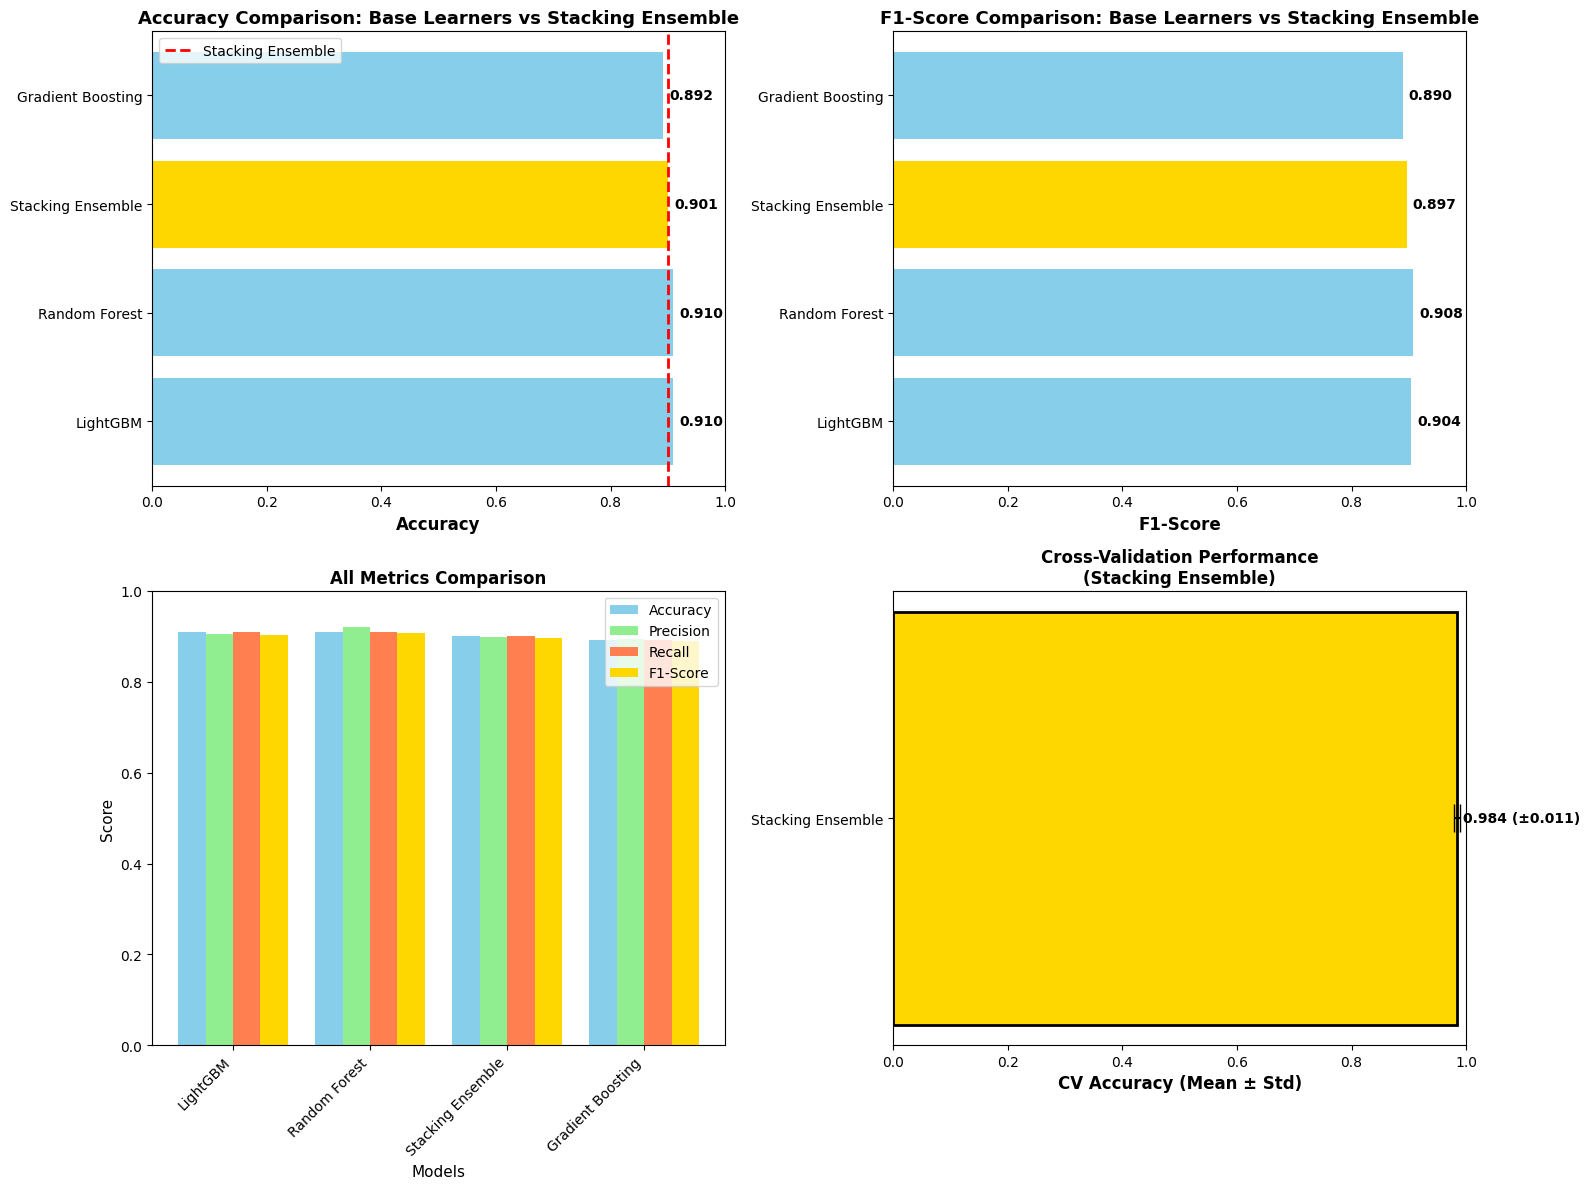

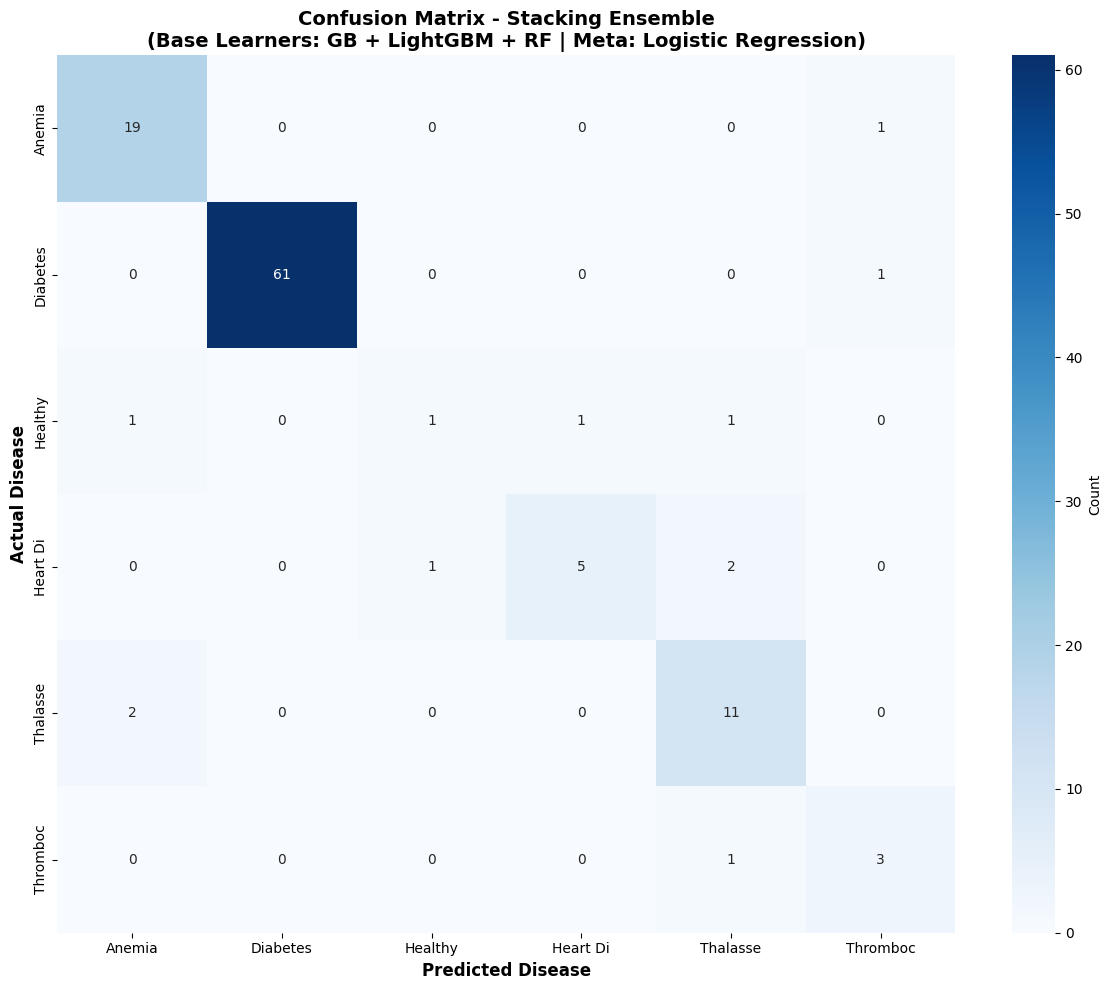

In [12]:
# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Prepare Data
    X_train, X_test, y_train, y_test = prepare_datasets()
    
    if X_train is not None:
        # 2. Balance Data
        X_train_resampled, y_train_resampled, label_encoder = preprocess_and_balance(X_train, y_train)
        
        # 3. Train Base Learners (for comparison)
        base_learners, base_results_df = train_base_learners(
            X_train_resampled, y_train_resampled, X_test, y_test, label_encoder
        )
        
        # 4. Build Stacking Ensemble
        stacking_model, estimators = build_stacking_ensemble(base_learners)
        
        # 5. Train & Evaluate Stacking Ensemble
        final_stacking_model, comparison_df = train_and_evaluate_stacking(
            stacking_model, X_train_resampled, y_train_resampled, 
            X_test, y_test, label_encoder, base_learners
        )
        
        # 6. Save Models
        print("\n" + "="*80)
        print("SAVING MODELS")
        print("="*80)
        
        # Save Stacking Ensemble
        joblib.dump(final_stacking_model, 'stacking_ensemble_model.pkl')
        print("✓ Stacking Ensemble saved as 'stacking_ensemble_model.pkl'")
        
        # Save Label Encoder
        joblib.dump(label_encoder, 'label_encoder.pkl')
        print("✓ Label Encoder saved as 'label_encoder.pkl'")
        
        # Save base learners (optional, for individual use)
        joblib.dump(base_learners, 'base_learners.pkl')
        print("✓ Base Learners saved as 'base_learners.pkl'")
        
        # Save comparison results
        comparison_df.to_csv('stacking_ensemble_comparison_results.csv', index=False)
        print("✓ Comparison results saved as 'stacking_ensemble_comparison_results.csv'")
        
        print("\n" + "="*80)
        print("SUCCESS! All files saved:")
        print("  - stacking_ensemble_model.pkl (Main Stacking Model)")
        print("  - base_learners.pkl (Individual Base Learners)")
        print("  - label_encoder.pkl")
        print("  - stacking_ensemble_comparison_results.csv")
        print("  - stacking_ensemble_comparison.png")
        print("  - stacking_ensemble_confusion_matrix.png")
        print("="*80)
        
        # Final Summary
        stacking_row = comparison_df[comparison_df['Type'] == 'Meta-Model'].iloc[0]
        best_base = comparison_df[comparison_df['Type'] == 'Base Learner'].iloc[0]
        
        print("\n" + "="*80)
        print("FINAL SUMMARY")
        print("="*80)
        print(f"Stacking Ensemble Performance:")
        print(f"  Accuracy: {stacking_row['Accuracy']:.4f}")
        print(f"  F1-Score: {stacking_row['F1-Score']:.4f}")
        print(f"\nBest Base Learner: {best_base['Model']}")
        print(f"  Accuracy: {best_base['Accuracy']:.4f}")
        print(f"  F1-Score: {best_base['F1-Score']:.4f}")
        print(f"\nImprovement: {((stacking_row['Accuracy'] - best_base['Accuracy']) / best_base['Accuracy'] * 100):.2f}%")
        print("="*80)
